### Importing Required Libraries

In this cell, we will import various libraries necessary for our deep learning model, including:

- **os**: To manage environment variables.
- **torch**: The main PyTorch library for building and training neural networks.
- **torch.nn**: Contains functionalities for building neural network layers.
- **Dataset and DataLoader**: To handle data efficiently during training and testing.
- **AdamW**: An optimizer for training the model.
- **transformers**: For loading pre-trained models and tokenizers from Hugging Face.
- **CRF**: Conditional Random Field, useful for sequence labeling tasks.
- **accuracy_score**: To compute the accuracy of model predictions.
- **matplotlib.pyplot**: For plotting graphs to visualize results.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torchcrf import CRF
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

### Defining Data Processing Classes

In this section, we define several classes for processing and preparing the data for our Named Entity Recognition (NER) task.

1. **`dataInput`**: A class that encapsulates an individual data entry including its identifier, words, and corresponding labels.

2. **`DataProcessor`**: An abstract base class to handle data retrieval with methods to be implemented in subclasses:
   - `get_data(data_dir)`: A method that should be overridden to fetch data from a directory.
   - `read_data(input_file)`: Reads labeled data from a file and formats it for processing.

3. **`DNRTI_DataProcessor`**: A subclass of `DataProcessor` that implements methods to handle specific data formats:
   - `__init__`: Initializes label types and a mapping from label names to indices.
   - `_create(raw_lists)`: Converts raw input data into instances of `dataInput`.
   - `get_data(data_dir)`: Fetches and processes data from the specified directory.
   - `get_label_map()`: Returns the mapping of labels to indices.

4. **`InputFeatures`**: A class structure to hold tokenized input and labels for model consumption:
   - Contains attributes such as `input_ids`, `input_mask`, `segment_ids`, `predict_mask`, and `label_ids`.

5. **`convert_example_to_feature(example, tokenizer, label_map, max_seq_length)`**: A function that converts a `dataInput` example into `InputFeatures` using a specified tokenizer.

6. **`NerDataset`**: A custom dataset class for handling NER data:
   - `__init__`: Initializes the dataset by converting examples into features.
   - `__len__`: Returns the number of samples in the dataset.
   - `__getitem__`: Retrieves a specific sample by index.
   - `collate_fn(batch)`: A static method to collate data into batches, padding sequences to the maximum length within the batch.

This setup prepares our dataset for training a neural network for NER tasks.

In [ ]:
class dataInput(object):
    def __init__(self, guid, words, labels):
        self.guid = guid
        self.words = words
        self.labels = labels

class DataProcessor(object):
    def get_data(self, data_dir):
        raise NotImplementedError()

    @classmethod
    def read_data(cls, input_file):
        with open(input_file, encoding='utf-8') as f:
            out_lists = []
            entries = f.read().strip().split("\n\n")
            for entry in entries:
                words, ner_labels = [], []
                for line in entry.splitlines():
                    pieces = line.strip().split()
                    if len(pieces) < 2:
                        continue
                    words.append(pieces[0])
                    ner_labels.append(pieces[-1])
                out_lists.append([words, ner_labels])
        return out_lists

class DNRTI_DataProcessor(DataProcessor):
    def __init__(self):
        self._label_types = [
            'X', '[CLS]', '[SEP]', 'O',
            'B-Area', 'B-Exp', 'B-Features', 'B-HackOrg',
            'B-Idus', 'B-OffAct', 'B-Org', 'B-Purp',
            'B-SamFile', 'B-SecTeam', 'B-Time', 'B-Tool', 'B-Way',
            'I-Area', 'I-Exp', 'I-Features', 'I-HackOrg',
            'I-Idus', 'I-OffAct', 'I-Org', 'I-Purp',
            'I-SamFile', 'I-SecTeam', 'I-Time', 'I-Tool', 'I-Way'
        ]
        self._label_map = {label: i for i, label in enumerate(self._label_types)}

    def _create(self, raw_lists):
        data = []
        for i, one in enumerate(raw_lists):
            guid = i
            words, labels = one
            data.append(dataInput(guid, words, labels))
        return data

    def get_data(self, data_dir):
        raw = self.read_data(data_dir)
        return self._create(raw)

    def get_label_map(self):
        return self._label_map

class InputFeatures:
    def __init__(self, input_ids, input_mask, segment_ids, predict_mask, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.predict_mask = predict_mask
        self.label_ids = label_ids


def convert_example_to_feature(example, tokenizer, label_map, max_seq_length):
    tokens = ['[CLS]']
    predict_mask = [0]
    label_ids = [label_map['[CLS]']]

    for word, label in zip(example.words, example.labels):
        sub_tokens = tokenizer.tokenize(word) or ['[UNK]']
        tokens.extend(sub_tokens)
        for i in range(len(sub_tokens)):
            if i == 0:
                predict_mask.append(1)
                label_ids.append(label_map[label])
            else:
                predict_mask.append(0)
                label_ids.append(label_map['X'])

    if len(tokens) > max_seq_length - 1:
        tokens = tokens[: max_seq_length - 1]
        predict_mask = predict_mask[: max_seq_length - 1]
        label_ids = label_ids[: max_seq_length - 1]

    tokens.append('[SEP]')
    predict_mask.append(0)
    label_ids.append(label_map['[SEP]'])

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    segment_ids = [0] * len(input_ids)
    input_mask = [1] * len(input_ids)

    return InputFeatures(input_ids, input_mask, segment_ids, predict_mask, label_ids)

class NerDataset(Dataset):
    def __init__(self, examples, tokenizer, label_map, max_seq_length):
        self.features = [convert_example_to_feature(ex, tokenizer, label_map, max_seq_length)
                         for ex in examples]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feat = self.features[idx]
        return (feat.input_ids, feat.input_mask,
                feat.segment_ids, feat.predict_mask, feat.label_ids)

    @staticmethod
    def collate_fn(batch):
        max_len = max(len(x[0]) for x in batch)
        padded = []
        for i in range(5):
            seqs = [item[i] for item in batch]
            padded.append([s + [0] * (max_len - len(s)) for s in seqs])

        input_ids = torch.LongTensor(padded[0])
        attention_mask = torch.LongTensor(padded[1])
        segment_ids = torch.LongTensor(padded[2])
        predict_mask = torch.ByteTensor(padded[3])
        label_ids = torch.LongTensor(padded[4])
        return input_ids, attention_mask, segment_ids, predict_mask, label_ids

### Setting File Paths and Output Directory

In this cell, we define the paths for our training, validation, and test data files along with the output directory:

- **`train_file`**: The path to the training data file (`train.txt`).
- **`valid_file`**: The path to the validation data file (`valid.txt`).
- **`test_file`**: The path to the test data file (`test.txt`).
- **`output_dir`**: The directory (`./output`) where model outputs and results will be saved.

We also ensure that the output directory exists by creating it if it doesn't already.

In [32]:
train_file = 'train.txt'
valid_file = 'valid.txt'
test_file  = 'test.txt'
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)

### Data Processing and Label Mapping

In this cell, we instantiate the `DNRTI_DataProcessor` class to process our dataset. We then retrieve the training, validation, and test datasets by calling the `get_data()` method with the respective file paths. Additionally, we obtain the label mapping using the `get_label_map()` method, which allows us to associate each label with its corresponding index. Finally, we determine the number of unique labels by calculating the length of the `label_map`. This setup is essential for preparing our data for training and evaluation.

In [33]:
processor = DNRTI_DataProcessor()
train_data = processor.get_data(train_file)
valid_data = processor.get_data(valid_file)
test_data  = processor.get_data(test_file)
label_map  = processor.get_label_map()
num_labels = len(label_map)

### Tokenizer and Hyperparameter Settings

In this cell, we perform the following initializations for our model:

1. **Tokenizer**: We load the pre-trained tokenizer using `AutoTokenizer` from the Transformers library, specifically the `SecBERT` model by `jackaduma`. The `do_lower_case=True` option indicates that the tokenizer should convert all characters to lowercase.

2. **Hyperparameters**: We define several hyperparameters relevant for training our model:
   - **`max_seq_length`**: The maximum length of input sequences (set to 128 tokens).
   - **`batch_size`**: The number of samples processed together in one iteration (set to 16).
   - **`epochs`**: The total number of times the model will iterate over the entire training dataset (set to 50).
   - **`learning_rate`**: The step size at each iteration while moving toward a minimum of the loss function (set to 3e-5).
   - **`hidden_dim`**: The size of hidden layers in the model (set to 256).
   - **`dropout_rate`**: The dropout rate to prevent overfitting (set to 0.0).

These configurations are essential for effectively training our NER model.

In [34]:
tokenizer = AutoTokenizer.from_pretrained('jackaduma/SecBERT', do_lower_case=True)
max_seq_length = 128
batch_size = 16
epochs = 50
learning_rate = 3e-5
hidden_dim = 256
dropout_rate = 0.0

### Data Overview

In this cell, we print important statistics about our datasets. We display the number of training samples, validation samples, and test samples. Additionally, we present the specified batch size. These metrics are essential for understanding the scale of our training process and evaluating the availability of data for model training and validation.

In [35]:
print(f"  Num data_train = {len(train_data)}")
print(f"  Num data_val   = {len(valid_data)}")
print(f"  Num data_test  = {len(test_data)}")
print(f"  Batch size     = {batch_size}")

  Num data_train = 5251
  Num data_val   = 662
  Num data_test  = 664
  Batch size     = 16


### Creating Data Loaders

In this cell, we create data loaders for our training, validation, and test datasets using the `DataLoader` class. For the training data loader (`train_loader`), we shuffle the data to ensure that the model does not learn any unintended patterns from the order of the samples. For the validation and test data loaders (`valid_loader` and `test_loader`), we do not shuffle the data, as we need to evaluate performance based on the original ordering of the dataset. Each data loader utilizes the `NerDataset` class, which handles the conversion of data into the appropriate format for model training. This setup is crucial for efficiently batching and feeding data into the model during training and evaluation.

In [36]:
train_loader = DataLoader(NerDataset(train_data, tokenizer, label_map, max_seq_length),
                              batch_size=batch_size, shuffle=True, collate_fn=NerDataset.collate_fn)
valid_loader = DataLoader(NerDataset(valid_data, tokenizer, label_map, max_seq_length),
                            batch_size=batch_size, shuffle=False, collate_fn=NerDataset.collate_fn)
test_loader  = DataLoader(NerDataset(test_data, tokenizer, label_map, max_seq_length),
                            batch_size=batch_size, shuffle=False, collate_fn=NerDataset.collate_fn)

### Defining the SecBERT_BiLSTM_CRF Model

In this cell, we define the `SecBERT_BiLSTM_CRF` class, which is a neural network model combining BERT, Bi-directional LSTM (BiLSTM), and Conditional Random Fields (CRF) for Named Entity Recognition (NER) tasks. The constructor initializes various components: it loads a pre-trained BERT model, sets up a dropout layer for regularization, constructs a BiLSTM layer that processes the BERT outputs, and a linear classifier to produce label scores. Additionally, a CRF layer is used to model the sequence dependencies of labels. The `forward` method defines the forward pass, where it processes input IDs and attention masks through the BERT model, applies dropout, feeds the result into the BiLSTM, and generates emission scores for classification. It also handles the case where labels are provided for training by returning the negative log likelihood of the CRF layer, or it decodes the predicted labels during inference.

In [37]:
class SecBERT_BiLSTM_CRF(nn.Module):
    def __init__(self, bert_model_name, hidden_dim, num_labels, dropout_rate=0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.bilstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=hidden_dim // 2,
            batch_first=True,
            bidirectional=True
        )
        self.classifier = nn.Linear(hidden_dim, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None, mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        seq_out = self.dropout(outputs.last_hidden_state)
        lstm_out, _ = self.bilstm(seq_out)
        emissions = self.classifier(lstm_out)

        if labels is not None:
            return -self.crf(emissions, labels, mask=mask, reduction='mean')
        return self.crf.decode(emissions, mask=mask)


### Training and Evaluation Functions

In this cell, we define two key functions for training and evaluating the model. The `train_epoch` function performs one complete epoch of training. It sets the model to training mode, iterates over batches from the data loader, and moves them to the specified device (CPU or GPU). It calculates the loss using the model's forward method, performs backpropagation, and updates the model parameters using the optimizer and learning rate scheduler. The function also implements gradient clipping for stability and accumulates the total loss for averaging.

The `evaluate_accuracy` function assesses the model's performance on the validation or test dataset. It sets the model to evaluation mode, retrieves predictions without tracking gradients for performance optimization, and compares the predicted labels with the true labels. Using the label mask, it accumulates the relevant predictions and computes the accuracy score using the `accuracy_score` function. These two functions are fundamental for the training loop and the evaluation process in our NER task.

In [38]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids, attention_mask, _, _, label_ids = [b.to(device) for b in batch]
        mask = attention_mask.bool()
        loss = model(input_ids, attention_mask=attention_mask, labels=label_ids, mask=mask)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate_accuracy(model, dataloader, device, label_map):
    model.eval()
    idx2label = {v: k for k, v in label_map.items()}
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, _, _, label_ids = [b.to(device) for b in batch]
            mask = attention_mask.bool()
            preds = model(input_ids, attention_mask=attention_mask, mask=mask)
            for p_seq, t_seq, m_seq in zip(preds, label_ids.tolist(), mask.tolist()):
                for p, t, m in zip(p_seq, t_seq, m_seq):
                    if m:
                        true_labels.append(t)
                        pred_labels.append(p)
    return accuracy_score(true_labels, pred_labels)


### Model Training and Evaluation

In this cell, we set up the device for computation, initializing the model, loss optimizer, and learning rate scheduler. We determine whether to use a GPU or CPU, then create an instance of the `SecBERT_BiLSTM_CRF` model and move it to the appropriate device. The AdamW optimizer is employed for model parameter updates, alongside a linear learning rate scheduler that adjusts the learning rate during training. 

As we enter the training loop, we execute multiple epochs, where each epoch consists of calculating the training loss and evaluating the model's accuracy on the validation set. The average training loss and validation accuracy are recorded for each epoch, and the model with the best validation accuracy is saved for later testing. After completing the training, we load the best model and evaluate its accuracy on the test dataset.

Finally, to visualize the training process, we plot the training losses and validation accuracies over the epochs using matplotlib. This provides insights into the model's performance and learning progression throughout the training phase.

Epoch 1/50 - Train Loss: 73.9433 - Val Accuracy: 0.7656
Epoch 2/50 - Train Loss: 29.1995 - Val Accuracy: 0.8524
Epoch 3/50 - Train Loss: 18.6233 - Val Accuracy: 0.8914
Epoch 4/50 - Train Loss: 12.4168 - Val Accuracy: 0.9096
Epoch 5/50 - Train Loss: 8.3516 - Val Accuracy: 0.9267
Epoch 6/50 - Train Loss: 5.5910 - Val Accuracy: 0.9289
Epoch 7/50 - Train Loss: 3.7087 - Val Accuracy: 0.9419
Epoch 8/50 - Train Loss: 2.5564 - Val Accuracy: 0.9386
Epoch 9/50 - Train Loss: 1.8441 - Val Accuracy: 0.9450
Epoch 10/50 - Train Loss: 1.4110 - Val Accuracy: 0.9467
Epoch 11/50 - Train Loss: 1.1048 - Val Accuracy: 0.9476
Epoch 12/50 - Train Loss: 0.8916 - Val Accuracy: 0.9489
Epoch 13/50 - Train Loss: 0.7234 - Val Accuracy: 0.9509
Epoch 14/50 - Train Loss: 0.6077 - Val Accuracy: 0.9487
Epoch 15/50 - Train Loss: 0.5229 - Val Accuracy: 0.9495
Epoch 16/50 - Train Loss: 0.4199 - Val Accuracy: 0.9509
Epoch 17/50 - Train Loss: 0.4026 - Val Accuracy: 0.9503
Epoch 18/50 - Train Loss: 0.3421 - Val Accuracy: 0.95

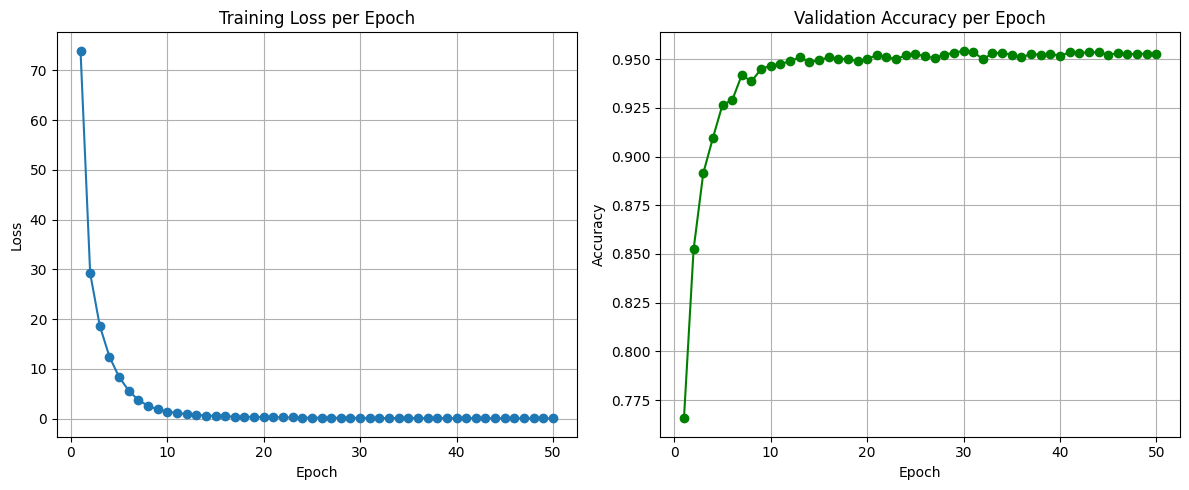

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SecBERT_BiLSTM_CRF('jackaduma/SecBERT', hidden_dim, num_labels, dropout_rate).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=int(0.1 * total_steps),
                                            num_training_steps=total_steps)


train_losses = []
val_accuracies = []

best_f1 = 0.0
best_model_path = os.path.join(output_dir, 'best_model.pt')

for epoch in range(1, epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    val_acc = evaluate_accuracy(model, valid_loader, device, label_map)
    
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f} - Val Accuracy: {val_acc:.4f}")
    
    if val_acc > best_f1:
        best_f1 = val_acc
        torch.save(model.state_dict(), best_model_path)

# Test evaluation
model.load_state_dict(torch.load(best_model_path, map_location=device))
test_acc = evaluate_accuracy(model, test_loader, device, label_map)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Best Validation Accuracy: {best_f1:.4f}")

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import torch
from torch.utils.data import DataLoader
import pandas as pd

def load_test_sentences_from_txt(path):
    sentences = []
    current_words = []
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.strip() == "":
                if current_words:
                    sentences.append(current_words)
                    current_words = []
            else:
                word = line.strip().split()[0]
                current_words.append(word)
        if current_words:
            sentences.append(current_words)
    return sentences

def predict_from_test_txt(model, tokenizer, label_map, processor, max_seq_length, test_path, device):
    sentences = load_test_sentences_from_txt(test_path)
    raw_data = [[sent, ['O'] * len(sent)] for sent in sentences]
    examples = processor._create(raw_data)
    dataset = NerDataset(examples, tokenizer, label_map, max_seq_length)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=NerDataset.collate_fn)

    idx2label = {v: k for k, v in label_map.items()}
    model.eval()

    all_words = []
    all_preds = []

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            input_ids, attention_mask, _, _, _ = [b.to(device) for b in batch]
            mask = attention_mask.bool()

            preds = model(input_ids=input_ids, attention_mask=attention_mask, mask=mask)
            input_ids = input_ids.squeeze(0).tolist()
            preds = preds[0]
            mask = mask.squeeze(0).tolist()

            tokens = tokenizer.convert_ids_to_tokens(input_ids)
            for token, pred_id, m in zip(tokens, preds, mask):
                if m and not token.startswith("##"):
                    all_words.append(token)
                    all_preds.append(idx2label[pred_id])

    return all_words, all_preds

# Usage
test_path = "test.txt"
words, preds = predict_from_test_txt(model, tokenizer, label_map, DNRTI_DataProcessor(), 128, test_path, device)

# Save to CSV
df = pd.DataFrame({"Word": words, "Predicted_Label": preds})
df.to_csv("ner_predictions.csv", index=False)
print("✅ Saved predictions to ner_predictions.csv")


TypeError: unhashable type: 'list'

### Making Predictions on a Sample Sentence

In this cell, we demonstrate how to make predictions for Named Entity Recognition (NER) using our trained model. We start by defining a sample sentence, which is tokenized using the previously loaded tokenizer. The tokenization process includes splitting the sentence into words, returning the necessary tensors, and applying truncation and padding as needed.

Once we prepare the `input_ids` and `attention_mask`, we set the model to evaluation mode to prevent gradients from being calculated, thus optimizing memory usage. We then pass the inputs through the model to obtain the output logits. The logits are used to derive the predicted labels by taking the argmax across the last dimension.

To map the predictions back to their corresponding tokens, we skip any sub-words and special tokens. Finally, we print the tokens along with their predicted NER tags, allowing us to visualize the model's predictions on the provided sentence.

In [ ]:
def create_test_loader_for_sentence(sentence, tokenizer, label_map, max_seq_length):
    sentenceSplit = sentence.split()
    raw_data = [[sentenceSplit, ['O'] * len(sentence.split())]]
    data_processor = DNRTI_DataProcessor()
    examples = data_processor._create(raw_data)
    features = [convert_example_to_feature(example, tokenizer, label_map, max_seq_length) for example in examples]
    test_dataset = NerDataset(examples, tokenizer, label_map, max_seq_length)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=NerDataset.collate_fn)
    return test_loader, sentenceSplit

def predict_data(model, dataloader, sentenceSplit, device, label_map):
    model.eval()
    idx2label = {v: k for k, v in label_map.items()}
    pred_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, _, _, label_ids = [b.to(device) for b in batch]
            mask = attention_mask.bool()
            preds = model(input_ids, attention_mask=attention_mask, mask=mask)
            
            for p_seq, m_seq in zip(preds, mask.tolist()):
                for p, m in zip(p_seq, m_seq):
                    if m:
                        pred_labels.append(p) 

    pred_labels = [idx2label[label] for label in pred_labels]
    print(f"{'Word':<15} {'Predicted Label'}")
    print("-" * 30)
    for word, label in zip(sentenceSplit, pred_labels):
        print(f"{word:<15} {label}")

    return pred_labels

In [ ]:
sentence = "New Orleans celebrates Mother's Day with a grand parade every year."
max_seq_length = 256  
test_loader, sentenceSplit = create_test_loader_for_sentence(sentence, tokenizer, label_map, max_seq_length)
test_acc = predict_data(model, test_loader, sentenceSplit, device, label_map)
print(len(test_acc))


Word            Predicted Label
------------------------------
New             [CLS]
Orleans         O
celebrates      O
Mother's        B-HackOrg
Day             X
with            O
a               X
grand           B-HackOrg
parade          X
every           X
year.           O


### Overall Summary of NER Model Implementation

In this Jupyter Notebook, we develop a Named Entity Recognition (NER) model that effectively combines BERT, a Bi-directional Long Short-Term Memory (BiLSTM) network, and Conditional Random Fields (CRF) to enhance entity recognition accuracy. We begin by importing essential libraries, including PyTorch and Transformers, for handling data, training, and evaluation tasks.

The heart of our approach lies in the `SecBERT_BiLSTM_CRF` class, where we initialize the model with several key components. First, we load a pre-trained BERT model from Hugging Face, which provides robust contextual embeddings for input tokens. BERT is capable of understanding the nuances of language through its transformer architecture, making it ideal for NER tasks.

Next, we incorporate a BiLSTM layer, which processes the embeddings generated by BERT. The BiLSTM layer is designed to capture contextual information from both directions—forward and backward—allowing it to understand the relationships and dependencies between tokens better. We set the hidden size of the BiLSTM to half of the defined hidden dimension because we are using a bidirectional setup, ensuring a more compact representation while still capturing essential contextual information.

After the BiLSTM, we apply a dropout layer to mitigate overfitting by randomly setting a fraction of input units to zero during training. This helps to improve the model's generalization to unseen data. Subsequently, we define a linear classifier that transforms the output from the BiLSTM into logits corresponding to the various entity labels defined in our dataset.

A crucial aspect of our model is the integration of a CRF layer, which enables the model to consider the dependencies between predicted labels for sequences. CRF is particularly beneficial in sequence labeling tasks, as it allows the model to enforce consistency within the sequence, improving the accuracy of the predicted labels by taking into account the relationships between adjacent entities.

Throughout the implementation, we define the `train_epoch` and `evaluate_accuracy` functions that facilitate model training and evaluation. The training function optimizes model parameters by minimizing the loss through backpropagation, while the evaluation function assesses the model's performance on validation and test datasets, providing metrics such as accuracy.

We leverage a GPU for efficient model training, significantly speeding up computations and allowing us to handle larger datasets. As we train the model over multiple epochs, we carefully monitor training loss and validation accuracy to determine the optimal model state.

After the training phase, we demonstrate how to make predictions using the trained model with a sample sentence. The tokenization process prepares the input for evaluation, and we map the model's predicted labels back to their corresponding tokens, allowing us to effectively display and analyze the identified named entities.

This comprehensive and structured approach to building, training, evaluating, and deploying the NER model utilizes modern deep learning techniques, enhancing the model's capability to recognize and classify named entities within natural language text accurately. 